In [41]:
from skimage import data_dir,io,color
import torch
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
import torch
from torch.autograd import Variable
from sklearn.model_selection import KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh



import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm 
import matplotlib as mpl




# Load three slice SPECT image

In [56]:
coll = io.ImageCollection(r'C:\Users\Ding1119\PyTorch-Spectral-clustering-master\SPECT_630_three\*.jpg')
#coll = io.ImageCollection(r'C:\Users\adm\SPECT_3_3\mask_three\*.jpg')
#coll = io.ImageCollection(r'C:\Users\adm\SPECT_3_3\all_SPECT_RGB\*.jpg')
DF=io.concatenate_images(coll)
#DF = DF[0:100]
#DF = DF[0:300]
DF = DF[0:1892]
DF= DF.reshape(1890,128*128*3)

DF = preprocessing.normalize(DF)

#dff = torch.tensor(DF)

# Combie three slice image to one

In [5]:
df = DF

step = 3
df = [df[i:i+step] for i in range(0,len(df),step)]
#print(dff1)
df = np.array(df)
df = df.reshape((630,3*49152))
np.array(df).shape

(630, 147456)

# Load true labels

In [8]:

import pandas as pd
LB = pd.read_csv(r"C:\Users\Ding1119\PyTorch-Spectral-clustering-master\Label_2.csv")

LB = LB['Label']

LB = LB.values

In [16]:

import pandas as pd
LB_test = pd.read_csv(r"C:\Users\Ding1119\PyTorch-Spectral-clustering-master\New_100_Label_2.csv")

LB_test = LB_test['Label']

#LB = LB[0:29]

In [9]:
# split_label to train and test

def split_test_LB(data):
    shuffled_indices=np.random.RandomState(seed=42).permutation(len(data))
    #test_set_size=int(len(data)*test_ratio)
    #test_indices =shuffled_indices[:test_set_size]
    train_indices_1=shuffled_indices[0:630]
    #train_indices_2=shuffled_indices[130:630]
    #train_indices_3=shuffled_indices[8:12]
    #train_indices_4=shuffled_indices[12:16]
    #train_indices_5=shuffled_indices[16:20]
    
    
    return data[train_indices_1]


def split_test(data):
    shuffled_indices=np.random.RandomState(seed=42).permutation(len(data))
    #test_set_size=int(len(data)*test_ratio)
    #test_indices =shuffled_indices[:test_set_size]
    train_indices_1=shuffled_indices[0:630]
    #train_indices_2=shuffled_indices[130:630]
    #train_indices_3=shuffled_indices[8:12]
    #train_indices_4=shuffled_indices[12:16]
    #train_indices_5=shuffled_indices[16:20]
    
    
    return data[train_indices_1]



In [11]:
all_LB = split_test_LB(LB)
all_split_df = split_test(df)
DF_y_test = all_LB[0]
DF_X_test = all_split_df[0]
DF_X_train = all_split_df[1]
DF_y_train = all_LB[1]

In [12]:

 
def distance_matrix(mat):
    d= ((mat.unsqueeze (0)-mat.unsqueeze (1))**2).sum (2)**0.5
    return d

 
def diffusion_distance(mat, sigma=8.0, alpha=1.0):
    D =distance_matrix(mat);
    K = torch.exp(-(torch.pow(torch.div(D,sigma) ,2))) # Kernel
    p = K.sum(1)
    K1 = K/(torch.pow(p.unsqueeze(1)*p,alpha)+1e-9) # alpha = 1 Laplace Beltrami, 0.5 Fokker Planck diffusion.
    v = torch.sqrt(K1.sum(1))
    A = K1/(1e-9+v.unsqueeze(1)*v)
    [u,s,v]=torch.svd(A)
    u=u/(1e-9+u[:,0].unsqueeze(1))
    return K1,u,s,A


# Load test 100 image

In [13]:
from skimage import data_dir,io,color
import torch
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA
import torch
from torch.autograd import Variable



import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm 
import matplotlib as mpl

coll = io.ImageCollection(r'C:\Users\Ding1119\PyTorch-Spectral-clustering-master\新100中間三張_scale_128_128\*.jpg')
#coll = io.ImageCollection(r'C:\Users\adm\SPECT_3_3\mask_three\*.jpg')
#coll = io.ImageCollection(r'C:\Users\adm\SPECT_3_3\all_SPECT_RGB\*.jpg')
Test=io.concatenate_images(coll)
#DF = DF[0:100]
#DF = DF[0:300]
Test = Test[0:300]
Test= Test.reshape(300,128*128*3)

Test = preprocessing.normalize(Test)

#dff = torch.tensor(DF)


In [15]:
df_test = Test

step = 3
df_test= [df_test[i:i+step] for i in range(0,len(df_test),step)]
#print(dff1)
df_test = np.array(df_test)
df_test = df_test.reshape((100,3*49152))
np.array(df_test).shape

(100, 147456)

In [18]:
DF_X_train = df
DF_y_train = LB
DF_y_test = LB_test
DF_X_test = df_test
print('DF_X_train shape',DF_X_train.shape)
print('DF_X_test shape',DF_X_test.shape)
print('DF_y_train shape',DF_y_train.shape)
print('DF_y_test shape', DF_y_test.shape )


DF_X_train shape (630, 147456)
DF_X_test shape (100, 147456)
DF_y_train shape (630,)
DF_y_test shape (100,)


# Split SPECT data into 25-folds 

In [21]:

X = DF_X_train
y = DF_y_train
train_X = []
Y_train =[]
test_X = []
Y_test = []
from sklearn.model_selection import RepeatedKFold
kf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=8)

#kf =  KFold(25)
#kf = KFold(n_splits=25)
for train_index, test_index in kf.split(X,y):
    train_X.append(X[train_index])
    Y_train.append(y[train_index])
    test_X.append(X[test_index])
    Y_test.append(y[test_index])
    print('train_index', train_index, 'test_index', test_index)

train_index [  1   2   3   4   6   7   8   9  10  11  12  13  14  15  17  19  20  21
  23  24  26  28  29  31  33  34  35  36  37  38  39  40  42  43  44  45
  46  47  48  49  51  52  53  54  55  57  59  60  61  62  65  67  68  69
  70  71  72  73  75  76  77  79  81  82  83  84  85  86  87  88  90  91
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 110 112 113 114
 115 116 117 118 119 120 121 122 123 124 127 128 129 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 160 161 164 166 168 169 170 171 172 174 176 177 178 179 180 183
 184 186 187 188 189 191 192 193 194 195 197 198 199 201 202 203 204 205
 206 209 211 212 213 214 215 216 217 218 219 220 221 222 223 225 226 227
 229 230 231 232 233 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 252 253 254 255 257 258 259 261 262 264 265 266 267 268
 269 270 271 272 273 274 275 277 280 281 282 283 285 286 288 289 291 293
 296 297 299 300 301 302 303 304 305 30

train_index [  0   1   3   4   5   8  11  12  13  15  16  17  18  21  22  23  24  25
  26  27  29  30  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  47  49  50  51  52  53  55  56  57  58  59  60  62  63  64  65  66  67
  68  69  70  71  72  73  74  76  77  78  79  80  82  83  84  86  87  88
  89  90  91  92  93  94  95  96  97  99 100 101 103 104 106 107 108 109
 110 111 113 114 116 117 119 120 121 122 124 125 126 127 128 129 130 131
 132 134 135 137 138 139 141 142 145 146 148 149 151 153 154 155 156 157
 158 159 162 163 164 165 166 167 168 171 172 173 175 176 177 178 179 180
 181 182 183 185 186 187 188 189 190 191 193 194 195 196 197 198 200 201
 202 203 204 207 208 209 210 211 212 213 216 218 219 221 222 223 224 225
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 247 249 250 251 253 254 255 256 257 258 259 260 261 262 263 264 265
 266 268 272 273 274 275 276 277 278 279 281 282 283 284 285 286 287 288
 289 290 291 292 294 295 298 299 300 30

train_index [  0   2   3   4   5   6   7   8   9  10  11  12  13  15  16  17  19  20
  21  22  23  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42
  44  45  47  48  51  53  54  55  56  57  58  59  61  62  63  65  66  67
  68  69  71  75  76  77  78  79  80  81  83  84  85  86  87  89  90  91
  92  93  94  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 115 116 117 118 119 120 121 122 123 124 128 129 130 131 132 133
 134 135 136 137 138 139 140 142 143 145 146 147 148 149 151 152 153 154
 155 156 157 158 159 160 161 162 163 165 166 167 168 171 173 174 175 176
 178 179 181 182 183 185 186 187 188 190 191 192 193 194 195 196 197 198
 199 200 201 203 204 206 207 208 210 211 212 213 214 217 219 220 221 222
 223 224 225 226 228 230 231 232 233 234 236 237 238 240 241 242 243 244
 246 247 249 250 252 254 255 256 257 258 259 260 261 262 263 264 265 266
 267 268 269 270 272 273 274 277 278 279 280 281 283 285 286 287 288 290
 292 294 295 296 297 298 299 300 301 30

train_index [  0   1   2   3   5   6   7   8   9  11  12  13  14  15  16  19  20  21
  23  24  25  27  28  29  30  33  34  35  37  38  39  40  41  42  43  44
  45  46  48  50  52  54  55  56  57  58  61  63  64  65  66  67  68  71
  72  73  74  75  77  79  80  81  83  84  86  87  90  92  93  94  95  96
  97  98  99 100 101 102 103 105 106 107 108 109 111 112 113 114 115 116
 118 120 121 123 124 125 126 127 129 130 131 132 133 134 136 137 139 140
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 162
 163 164 166 167 168 169 170 172 173 174 176 177 179 180 181 182 184 185
 186 187 188 189 191 192 195 196 197 198 199 200 201 203 204 206 207 208
 210 211 212 213 214 216 218 219 220 221 223 224 225 226 227 228 231 232
 233 235 236 238 239 240 244 245 247 248 249 251 252 253 254 255 256 258
 259 260 261 262 263 264 265 266 267 269 270 273 274 275 276 277 278 280
 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 300 301 302 303 304 306 310 311 312 31

train_index [  0   1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  18  19
  20  23  25  26  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  47  49  51  52  53  54  56  59  60  61  62  63  64  65
  67  68  69  70  71  72  73  74  75  76  78  79  80  83  84  85  86  87
  88  89  90  91  92  94  95  96  97  99 100 101 102 103 104 107 108 109
 110 112 113 114 115 116 117 118 119 120 121 122 123 125 126 127 128 129
 131 132 133 134 135 136 137 140 141 142 143 145 146 148 150 151 152 153
 154 156 157 158 159 163 164 165 166 168 170 172 173 174 175 176 177 178
 179 180 182 183 185 186 188 189 190 191 192 194 195 197 199 200 205 206
 207 209 210 214 215 216 217 219 220 221 222 223 224 225 227 228 229 230
 231 232 233 234 236 237 238 239 240 241 242 244 246 247 248 249 251 252
 253 255 256 259 260 262 263 264 265 266 267 268 269 270 271 272 273 274
 275 277 278 279 280 281 282 283 284 285 286 287 289 290 293 294 295 296
 297 298 300 301 302 304 305 306 307 30

train_index [  1   2   3   4   5   6   7   8  10  11  13  14  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  35  36  37  39  40  41
  42  43  44  45  47  48  49  50  51  54  55  56  57  58  59  60  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  77  78  79  80  83  84
  85  87  88  89  91  92  93  94  95  96  97  98  99 100 101 104 105 110
 111 112 113 114 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 133 134 135 136 137 138 139 140 141 144 145 146 147 148 149 150 151
 152 153 154 155 156 158 159 160 161 162 164 165 166 168 169 172 173 174
 175 176 177 178 179 180 183 184 185 186 187 188 189 190 191 193 194 195
 199 201 203 204 205 207 208 210 211 212 213 215 216 218 220 221 223 224
 226 227 229 230 232 233 234 237 238 239 240 241 242 243 244 247 248 249
 250 254 255 256 257 259 260 261 262 263 264 267 268 269 270 271 272 275
 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 295 296
 297 298 299 300 301 302 303 304 305 30

train_index [  0   1   2   3   4   6   7   8   9  10  12  13  14  15  17  18  20  22
  24  26  27  28  29  30  31  32  33  34  35  36  38  39  40  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  57  59  61  62  63  64  65
  68  69  70  72  73  74  75  76  77  78  80  81  82  83  84  85  86  87
  89  90  94  95  96  97  98 100 101 102 103 104 106 107 108 109 112 114
 115 116 117 119 121 124 125 128 129 130 131 132 133 134 135 137 140 142
 143 144 145 146 149 150 151 152 153 154 155 156 157 158 159 160 162 163
 165 167 168 169 170 171 172 173 174 175 177 178 179 181 182 183 184 186
 188 189 190 191 192 193 194 195 196 197 198 200 201 202 203 205 206 208
 209 210 211 212 213 214 215 216 217 219 220 221 222 223 224 225 226 228
 230 231 232 234 235 236 238 239 243 245 246 247 248 249 251 252 253 254
 255 256 258 259 260 262 264 265 266 268 270 271 272 273 274 275 276 277
 278 281 283 284 285 286 288 289 290 291 292 293 294 295 296 297 298 300
 301 302 303 304 306 308 309 310 311 31

In [23]:
for train_index in range(25):
    print('Number of ',train_index,'Folds')
    print('train_X shape:',train_X[train_index].shape)
    print('train_Y shape:',Y_train[train_index].shape)
    print('test_X shape:',test_X[train_index].shape)
    print('test_Y shape:',Y_test[train_index].shape)

Number of  0 Folds
train_X shape: (504, 147456)
train_Y shape: (504,)
test_X shape: (126, 147456)
test_Y shape: (126,)
Number of  1 Folds
train_X shape: (504, 147456)
train_Y shape: (504,)
test_X shape: (126, 147456)
test_Y shape: (126,)
Number of  2 Folds
train_X shape: (504, 147456)
train_Y shape: (504,)
test_X shape: (126, 147456)
test_Y shape: (126,)
Number of  3 Folds
train_X shape: (504, 147456)
train_Y shape: (504,)
test_X shape: (126, 147456)
test_Y shape: (126,)
Number of  4 Folds
train_X shape: (504, 147456)
train_Y shape: (504,)
test_X shape: (126, 147456)
test_Y shape: (126,)
Number of  5 Folds
train_X shape: (504, 147456)
train_Y shape: (504,)
test_X shape: (126, 147456)
test_Y shape: (126,)
Number of  6 Folds
train_X shape: (504, 147456)
train_Y shape: (504,)
test_X shape: (126, 147456)
test_Y shape: (126,)
Number of  7 Folds
train_X shape: (504, 147456)
train_Y shape: (504,)
test_X shape: (126, 147456)
test_Y shape: (126,)
Number of  8 Folds
train_X shape: (504, 147456)


# Diffusion Maps

In [24]:

def distance_matrix(mat):
    d= ((mat.unsqueeze (0)-mat.unsqueeze (1))**2).sum (2)**0.5
    return d

 
def diffusion_distance(mat, sigma=8.0, alpha=1.0):
    D =distance_matrix(mat);
    K = torch.exp(-(torch.pow(torch.div(D,sigma) ,2))) # Kernel
    p = K.sum(1)
    K1 = K/(torch.pow(p.unsqueeze(1)*p,alpha)+1e-9) # alpha = 1 Laplace Beltrami, 0.5 Fokker Planck diffusion.
    v = torch.sqrt(K1.sum(1))
    A = K1/(1e-9+v.unsqueeze(1)*v)
    [u,s,v]=torch.svd(A)
    u=u/(1e-9+u[:,0].unsqueeze(1))
    return u


In [43]:
neighbors = np.arange(1, 100,20)
LLE_accuracy = np.empty(len(neighbors))
DM_accuracy_SPECT_three = np.empty(len(neighbors))
ISOMAP_accuracy = np.empty(len(neighbors))
KPCA_accuracy = np.empty(len(neighbors))

# Diffusion Maps + LDA methods

In [44]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression


SPECT_DM_three_accuracy = []
SPECT_DM_three_precision = []
SPECT_DM_three_sensitivity = []
SPECT_DM_three_specificity = []


neighbors = np.arange(0, 25)
#train_accuracy = np.empty(len(neighbors))
DM_accuracy_SPECT_three = np.empty(len(neighbors))

TABLE = []


for k in range(25):
    
    print("Training on Fold: ",k+1)
    
    
    # 630 of SPECT training data
    
    X_train_1 = train_X[k].reshape((504,147456))
    
    
    # 100 of SPECT testing data
    
    X_test_1 = DF_X_test.reshape((100,147456))
    
    Y_train_1 =Y_train[k]
    #Y_test_1 = Y_test[k]
    
    Y_test_1 = DF_y_test
    
    print('Training size propotion')
    propotion_count = pd.Series(Y_train_1).value_counts() 
    print(propotion_count)
    
    dff_1 = euclidean_distances(X_train_1 ,X_train_1)
    dff_1 = torch.tensor(dff_1)
    u_1 = diffusion_distance(dff_1,8.0,0.5)
   
    
    
    u_train_select_1 = u_1[:,1:301]
    
    
    Y_1 = np.matmul(dff_1,u_train_select_1)
    
    
    ################## Testing ############################
    

    #dff_t = X_test_1


    X_test_d= euclidean_distances(X_test_1,X_train_1)

    #X_test_d = torch.tensor(X_test_d)
    
    
    Y_t_1 = np.matmul(X_test_d,u_train_select_1)
    
    #model_linear = SVC(kernel='linear')
    #model_linear.fit(Y_1 , Y_train_1)

    # predict
    #y_pred = model_linear.predict(Y_t_1 )
    
    
    clf = LinearDiscriminantAnalysis()
    clf.fit(Y_1 , Y_train_1)
    


    # predict
    y_pred = clf.predict(Y_t_1 )
    
    
    print(classification_report(y_true=Y_test_1, y_pred=y_pred))
    
    TABLE.append(y_pred)
    
    #cm = confusion_matrix(Y_test_1, y_pred)
    #plot_confusion_matrix(cm,class_names)
    #plt.show()
    u_new_d = euclidean_distances(X_test_1,X_test_1)
    
    u_t = diffusion_distance(torch.tensor(X_test_d), sigma=8.0, alpha=1.0)
    u_t1 = diffusion_distance(torch.tensor( u_new_d), sigma=8.0, alpha=1.0)
    DM_full = euclidean_distances(u_t ,u_t)
    DM_ext = euclidean_distances(u_t1 ,u_t1)
    
     # test 30張
    #print('distance :', LA.norm(np.array(DM_full)-np.array(DM_ext), 'fro') )


#ytrain = Y_val

    
    print('=============================================')
    U_test = metrics.accuracy_score(y_true=Y_test_1, y_pred=y_pred)
    
    
    print(U_test)
    
    DM_accuracy_SPECT_three[k] = U_test

    cm1 = confusion_matrix(y_true=Y_test_1, y_pred=y_pred)
    print('Confusion Matrix : \n', cm1)

    total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    SPECT_DM_three_accuracy.append(accuracy1)
    
    print ('Accuracy : ', accuracy1)

    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    SPECT_DM_three_sensitivity.append(cm1[0,0]/(cm1[0,0]+cm1[0,1]))
    print('Sensitivity : ', sensitivity1 )
    
    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    SPECT_DM_three_specificity.append(cm1[1,1]/(cm1[1,0]+cm1[1,1]))
    print('Specificity : ', specificity1)
    
    precision = precision_score(y_true=Y_test_1, y_pred=y_pred, average='weighted')
    SPECT_DM_three_precision.append(precision)
    
    
    
    
    
    

Training on Fold:  1
Training size propotion
1    264
0    240
dtype: int64
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        53
           1       0.83      0.85      0.84        47

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

0.85
Confusion Matrix : 
 [[45  8]
 [ 7 40]]
Accuracy :  0.85
Sensitivity :  0.8490566037735849
Specificity :  0.851063829787234
Training on Fold:  2
Training size propotion
1    261
0    243
dtype: int64
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        53
           1       0.95      0.81      0.87        47

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100

0.89
Confusion Matrix : 
 [[51  2]
 [ 9 38]]
Accuracy :  0.89
Sen

0.88
Confusion Matrix : 
 [[50  3]
 [ 9 38]]
Accuracy :  0.88
Sensitivity :  0.9433962264150944
Specificity :  0.8085106382978723
Training on Fold:  16
Training size propotion
1    267
0    237
dtype: int64
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        53
           1       0.93      0.83      0.88        47

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100

0.89
Confusion Matrix : 
 [[50  3]
 [ 8 39]]
Accuracy :  0.89
Sensitivity :  0.9433962264150944
Specificity :  0.8297872340425532
Training on Fold:  17
Training size propotion
1    261
0    243
dtype: int64
              precision    recall  f1-score   support

           0       0.84      0.98      0.90        53
           1       0.97      0.79      0.87        47

    accuracy                           0.89       100
   macro avg       0.91      0.88      0.

In [45]:
DM_df = pd.DataFrame(SPECT_DM_three_accuracy)
print(DM_df.describe())

               0
count  25.000000
mean    0.902000
std     0.019579
min     0.850000
25%     0.890000
50%     0.910000
75%     0.910000
max     0.930000


# LLE + LDA methods

In [46]:
neighbors = np.arange(0, 25)
#train_accuracy = np.empty(len(neighbors))
LLE_accuracy = np.empty(len(neighbors))

TABLE = []


for k in range(25):
    
    print("Training on Fold: ",k+1)
    
    
    
    
    X_train_1 = train_X[k].reshape((504,147456))
    
    
    #X_test_1 = test_X[k].reshape((126,3*49152))
    
    X_test_1 = DF_X_test.reshape((100,147456))
    
    Y_train_1 =Y_train[k]
    #Y_test_1 = Y_test[k]
    
    Y_test_1 = DF_y_test
    
    print('Training size propotion')
    propotion_count = pd.Series(Y_train_1).value_counts() 
    print(propotion_count)
    
    dff_1 = euclidean_distances(X_train_1 ,X_train_1)
    dff_1 = torch.tensor(dff_1)
    u_1 = LocallyLinearEmbedding(n_components=200, n_neighbors=50).fit_transform(dff_1)
    
   
    
    
    u_train_select_1 = u_1[:,1:301]
    
    
    Y_1 = np.matmul(dff_1,u_train_select_1)
    
    
    ################## Testing ############################
    

    #dff_t = X_test_1


    X_test_d= euclidean_distances(X_test_1,X_train_1)

    #X_test_d = torch.tensor(X_test_d)
    
    
    Y_t_1 = np.matmul(X_test_d,u_train_select_1)
    
    #model_linear = SVC(kernel='linear')
    #model_linear.fit(Y_1 , Y_train_1)

    # predict
    #y_pred = model_linear.predict(Y_t_1 )
    clf = LinearDiscriminantAnalysis()
    clf.fit(Y_1 , Y_train_1)
    


    # predict
    y_pred = clf.predict(Y_t_1 )
    
    
    print(classification_report(y_true=Y_test_1, y_pred=y_pred))
    
    TABLE.append(y_pred)
    
    #cm = confusion_matrix(Y_test_1, y_pred)
    #plot_confusion_matrix(cm,class_names)
    #plt.show()



#ytrain = Y_val

    
    print('=============================================')
    U_test = metrics.accuracy_score(y_true=Y_test_1, y_pred=y_pred)
    
    
    print(U_test)
    
    LLE_accuracy[k] = U_test

    
    
    
    
    
    
    

Training on Fold:  1
Training size propotion
1    264
0    240
dtype: int64
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        53
           1       0.93      0.85      0.89        47

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100

0.9
Training on Fold:  2
Training size propotion
1    261
0    243
dtype: int64
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        53
           1       0.87      0.85      0.86        47

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

0.87
Training on Fold:  3
Training size propotion
1    268
0    236
dtype: int64
              precision    recall  f1-score   support

           0       0.85      0.98      0.91        53


              precision    recall  f1-score   support

           0       0.84      0.92      0.88        53
           1       0.90      0.81      0.85        47

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

0.87
Training on Fold:  20
Training size propotion
1    267
0    237
dtype: int64
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        53
           1       0.91      0.87      0.89        47

    accuracy                           0.90       100
   macro avg       0.90      0.90      0.90       100
weighted avg       0.90      0.90      0.90       100

0.9
Training on Fold:  21
Training size propotion
1    267
0    237
dtype: int64
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        53
           1       0.85      0.94      0.89        47

    accuracy       

# ISOMAP + LDA methods

In [47]:

neighbors = np.arange(0, 25)
#train_accuracy = np.empty(len(neighbors))
ISOMAP_accuracy = np.empty(len(neighbors))

TABLE = []


for k in range(25):
    
    print("Training on Fold: ",k+1)
    
    
    
    
    X_train_1 = train_X[k].reshape((504,147456))
    
    
    #X_test_1 = test_X[k].reshape((126,3*49152))
    
    X_test_1 = DF_X_test.reshape((100,147456))
    
    Y_train_1 =Y_train[k]
    #Y_test_1 = Y_test[k]
    
    Y_test_1 = DF_y_test
    
    print('Training size propotion')
    dist = pd.Series(Y_train_1).value_counts() 
    print(dist)
    
    dff_1 = euclidean_distances(X_train_1 ,X_train_1)
    dff_1 = torch.tensor(dff_1)
    u_1 = Isomap(n_neighbors = 50, n_components = 150, eigen_solver='auto').fit_transform(dff_1)
    
   
    
    
    u_train_select_1 = u_1[:,1:301]
    
    
    Y_1 = np.matmul(dff_1,u_train_select_1)
    
    
    ################## Testing ############################
    

    #dff_t = X_test_1


    X_test_d= euclidean_distances(X_test_1,X_train_1)

    #X_test_d = torch.tensor(X_test_d)
    
    
    Y_t_1 = np.matmul(X_test_d,u_train_select_1)
    
    #model_linear = SVC(kernel='linear')
    #model_linear.fit(Y_1 , Y_train_1)

    # predict
    #y_pred = model_linear.predict(Y_t_1 )
    clf = LinearDiscriminantAnalysis()
    clf.fit(Y_1 , Y_train_1)
    


    # predict
    y_pred = clf.predict(Y_t_1 )
    
    
    print(classification_report(y_true=Y_test_1, y_pred=y_pred))
    
    TABLE.append(y_pred)
    
    #cm = confusion_matrix(Y_test_1, y_pred)
    #plot_confusion_matrix(cm,class_names)
    #plt.show()



#ytrain = Y_val

    
    print('=============================================')
    U_test = metrics.accuracy_score(y_true=Y_test_1, y_pred=y_pred)
    
    
    print(U_test)
    
    ISOMAP_accuracy[k] = U_test

    
    
    
    
    
    
    

Training on Fold:  1
Training size propotion
1    264
0    240
dtype: int64
              precision    recall  f1-score   support

           0       0.87      0.77      0.82        53
           1       0.77      0.87      0.82        47

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100

0.82
Training on Fold:  2
Training size propotion
1    261
0    243
dtype: int64
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        53
           1       0.93      0.81      0.86        47

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100

0.88
Training on Fold:  3
Training size propotion
1    268
0    236
dtype: int64
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        53

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        53
           1       0.81      0.81      0.81        47

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

0.82
Training on Fold:  20
Training size propotion
1    267
0    237
dtype: int64
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        53
           1       0.85      0.85      0.85        47

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

0.86
Training on Fold:  21
Training size propotion
1    267
0    237
dtype: int64
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        53
           1       0.79      0.87      0.83        47

    accuracy      

# KPCA + LDA methods

In [54]:
def rbf_kernel_pca(X, gamma, n_components):
    
    sq_dists = pdist(X, 'sqeuclidean')
 
   
    mat_sq_dists = squareform(sq_dists)
 
    
    K = exp(-gamma * mat_sq_dists)
 
   
    N = K.shape[0]
    one_n = np.ones((N,N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
 
    
    eigvals, eigvecs = eigh(K)
 
    
    X_pc = np.column_stack((eigvecs[:, -i]
                            for i in range(1, n_components + 1)))
 
    #return X_pc,mat_sq_dists,K
    return X_pc

In [49]:
neighbors = np.arange(0, 25)
#train_accuracy = np.empty(len(neighbors))
KPCA_accuracy = np.empty(len(neighbors))

TABLE = []


for k in range(25):
    
    print("Training on Fold: ",k+1)
    
    
    
    
    X_train_1 = train_X[k].reshape((504,147456))
    
    
    #X_test_1 = test_X[k].reshape((126,3*49152))
    
    X_test_1 = DF_X_test.reshape((100,147456))
    
    Y_train_1 =Y_train[k]
    #Y_test_1 = Y_test[k]
    
    Y_test_1 = DF_y_test
    
    print('Training size propotion')
    dist = pd.Series(Y_train_1).value_counts() 
    print(dist)
    
    dff_1 = euclidean_distances(X_train_1 ,X_train_1)
    dff_1 = torch.tensor(dff_1)
    u_1 = rbf_kernel_pca(dff_1, 17, 30)
   
    
    
    u_train_select_1 = u_1[:,1:301]
    
    
    Y_1 = np.matmul(dff_1,u_train_select_1)
    
    
    ################## Testing ############################
    

    #dff_t = X_test_1


    X_test_d= euclidean_distances(X_test_1,X_train_1)

    #X_test_d = torch.tensor(X_test_d)02
    
    
    Y_t_1 = np.matmul(X_test_d,u_train_select_1)
    
    #model_linear = SVC(kernel='linear')
    #model_linear.fit(Y_1 , Y_train_1)

    # predict
    #y_pred = model_linear.predict(Y_t_1 )
    clf = LinearDiscriminantAnalysis()
    clf.fit(Y_1 , Y_train_1)
    


    # predict
    y_pred = clf.predict(Y_t_1 )
    
    
    print(classification_report(y_true=Y_test_1, y_pred=y_pred))
    
    TABLE.append(y_pred)
    
    #cm = confusion_matrix(Y_test_1, y_pred)
    #plot_confusion_matrix(cm,class_names)
    #plt.show()



#ytrain = Y_val

    
    print('=============================================')
    U_test = metrics.accuracy_score(y_true=Y_test_1, y_pred=y_pred)
    
    
    print(U_test)
    
    KPCA_accuracy[k] = U_test

    
    
    
    
    
    
    

Training on Fold:  1
Training size propotion
1    264
0    240
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.77      0.89      0.82        53
           1       0.85      0.70      0.77        47

    accuracy                           0.80       100
   macro avg       0.81      0.79      0.80       100
weighted avg       0.81      0.80      0.80       100

0.8
Training on Fold:  2
Training size propotion
1    261
0    243
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.79      0.79      0.79        53
           1       0.77      0.77      0.77        47

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100

0.78
Training on Fold:  3
Training size propotion
1    268
0    236
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.85      0.75      0.80        53
           1       0.75      0.85      0.80        47

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100

0.8
Training on Fold:  4
Training size propotion
1    263
0    241
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.79      0.79      0.79        53
           1       0.77      0.77      0.77        47

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100

0.78
Training on Fold:  5
Training size propotion
1    264
0    240
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.77      0.81      0.79        53
           1       0.77      0.72      0.75        47

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100

0.77
Training on Fold:  6
Training size propotion
1    262
0    242
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.78      0.81      0.80        53
           1       0.78      0.74      0.76        47

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100

0.78
Training on Fold:  7
Training size propotion
1    272
0    232
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.85      0.77      0.81        53
           1       0.77      0.85      0.81        47

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

0.81
Training on Fold:  8
Training size propotion
1    264
0    240
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.85      0.77      0.81        53
           1       0.77      0.85      0.81        47

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

0.81
Training on Fold:  9
Training size propotion
1    260
0    244
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.83      0.81      0.82        53
           1       0.79      0.81      0.80        47

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

0.81
Training on Fold:  10
Training size propotion
1    262
0    242
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.80      0.85      0.83        53
           1       0.82      0.77      0.79        47

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

0.81
Training on Fold:  11
Training size propotion
1    264
0    240
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.85      0.85      0.85        53
           1       0.83      0.83      0.83        47

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

0.84
Training on Fold:  12
Training size propotion
1    262
0    242
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.85      0.75      0.80        53
           1       0.75      0.85      0.80        47

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.81      0.80      0.80       100

0.8
Training on Fold:  13
Training size propotion
1    261
0    243
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.77      0.87      0.81        53
           1       0.82      0.70      0.76        47

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100

0.79
Training on Fold:  14
Training size propotion
1    262
0    242
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.83      0.83      0.83        53
           1       0.81      0.81      0.81        47

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

0.82
Training on Fold:  15
Training size propotion
1    271
0    233
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.83      0.75      0.79        53
           1       0.75      0.83      0.79        47

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100

0.79
Training on Fold:  16
Training size propotion
1    267
0    237
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.79      0.83      0.81        53
           1       0.80      0.74      0.77        47

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100

0.79
Training on Fold:  17
Training size propotion
1    261
0    243
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.80      0.81      0.80        53
           1       0.78      0.77      0.77        47

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100

0.79
Training on Fold:  18
Training size propotion
1    267
0    237
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.80      0.83      0.81        53
           1       0.80      0.77      0.78        47

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

0.8
Training on Fold:  19
Training size propotion
1    258
0    246
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.79      0.83      0.81        53
           1       0.80      0.74      0.77        47

    accuracy                           0.79       100
   macro avg       0.79      0.79      0.79       100
weighted avg       0.79      0.79      0.79       100

0.79
Training on Fold:  20
Training size propotion
1    267
0    237
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.80      0.75      0.78        53
           1       0.74      0.79      0.76        47

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100

0.77
Training on Fold:  21
Training size propotion
1    267
0    237
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.81      0.83      0.82        53
           1       0.80      0.79      0.80        47

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

0.81
Training on Fold:  22
Training size propotion
1    254
0    250
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.79      0.92      0.85        53
           1       0.89      0.72      0.80        47

    accuracy                           0.83       100
   macro avg       0.84      0.82      0.83       100
weighted avg       0.84      0.83      0.83       100

0.83
Training on Fold:  23
Training size propotion
1    266
0    238
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.84      0.79      0.82        53
           1       0.78      0.83      0.80        47

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

0.81
Training on Fold:  24
Training size propotion
1    266
0    238
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.82      0.79      0.81        53
           1       0.78      0.81      0.79        47

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100

0.8
Training on Fold:  25
Training size propotion
1    267
0    237
dtype: int64


C:\Users\Ding1119\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


              precision    recall  f1-score   support

           0       0.80      0.85      0.83        53
           1       0.82      0.77      0.79        47

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

0.81


# Plot twenty-five folds accuracy

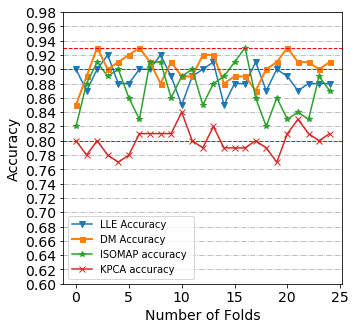

In [53]:
# Generate plot
plt.figure(figsize=(5,5))
#plt.title('Manifold learning in LDA classifier with dimension (30)',fontsize=14)
#plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
my_y_ticks = np.arange(0.6, 1, 0.02)
plt.plot(neighbors, LLE_accuracy, label = 'LLE Accuracy',marker = 'v')
plt.plot(neighbors, SPECT_DM_three_accuracy,linewidth=2,marker='s',markersize=5, label = 'DM Accuracy')
plt.plot(neighbors,ISOMAP_accuracy,label = 'ISOMAP accuracy ',marker = '*')
plt.plot(neighbors,KPCA_accuracy,label = 'KPCA accuracy ',marker = 'x')



plt.legend()
plt.xlabel('Number of Folds',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.yticks(my_y_ticks)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y',linestyle='-.')
plt.axhline(y=max(SPECT_DM_three_accuracy), c="r", ls="--", lw=1)
plt.axhline(y=0.90, c="r", ls="--", lw=1)
plt.axhline(y=0.8, c="r", ls="--", lw=1)
plt.show()